# Clustering de documents

## Imports

In [80]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [81]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vkvvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [82]:
data_path = "../tp4/data/txt/"

## Choisir une décennie

In [83]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [84]:
files = [f for f in sorted(os.listdir(data_path))]

In [85]:
# Exemple de fichiers
files[:5]

['KB_JB1051_1924-11-19_01-00002.txt',
 'KB_JB1051_1925-07-19_01-00003.txt',
 'KB_JB1051_1925-10-03_01-00004.txt',
 'KB_JB1051_1925-11-03_01-00004.txt',
 'KB_JB421_1900-03-26_01-00001.txt']

In [86]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [87]:
# Exemple de textes
texts[0][:400]

"mmm me LE ORABEAU ROUGE La Bataille Ouvrière LA GREVE DE « LA CHAUSSURE v A FOREST Les ouvriwrei «t ouvriers continuent, avec la mutne unanimité «t la même volonté tenue de triompher, le mouvement déclenché par le patron. Nous pouvons même considérer que le terme « grève » ne s'applique pus exactement à ce mouvement. 11 s agit plutôt d'un « lock-out » puisque la Vï* rectum de La Société « La Chaus"

## Vectoriser les documents à l'aide de TF-IDF

In [88]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [89]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1, #beaucoup donc on peut réduire
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [90]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [91]:
# Détail de la matrice
tfidf_vectors
tfidf_vectors.shape

(407, 3933)

### Imprimer le vecteur tf-IDF du premier document

In [92]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

syndicat    0.287496
grève       0.172482
statuts     0.170188
sections    0.157402
employés    0.153185
              ...   
farine      0.000000
fasse       0.000000
fatigue     0.000000
faudra      0.000000
♦           0.000000
Length: 3933, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [93]:
cosine([1, 2, 3], [1, 2, 3])

0

In [94]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [95]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [96]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [97]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [98]:
clusters = km_model.fit_predict(tfidf_vectors)

In [99]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [100]:
pprint(dict(clustering))

{0: ['KB_JB685_1900-04-21_01-0001.txt',
     'KB_JB685_1902-07-24_01-0001.txt',
     'KB_JB685_1902-09-02_01-0001.txt',
     'KB_JB685_1902-11-14_01-0001.txt',
     'KB_JB685_1903-03-28_01-0001.txt',
     'KB_JB685_1904-07-05_01-0002.txt',
     'KB_JB685_1904-08-13_01-0002.txt',
     'KB_JB685_1904-08-20_01-0003.txt',
     'KB_JB685_1905-07-14_01-0002.txt',
     'KB_JB685_1905-09-01_01-0002.txt',
     'KB_JB685_1905-09-04_01-0002.txt',
     'KB_JB685_1906-08-26_01-0002.txt',
     'KB_JB685_1906-12-03_01-0002.txt',
     'KB_JB685_1907-10-09_01-0003.txt',
     'KB_JB685_1907-10-23_01-0003.txt',
     'KB_JB685_1908-06-11_01-0001.txt',
     'KB_JB685_1908-10-19_01-0002.txt',
     'KB_JB685_1908-11-28_01-0002.txt',
     'KB_JB685_1909-05-03_01-0001.txt',
     'KB_JB685_1909-08-21_01-0001.txt',
     'KB_JB685_1909-09-27_01-0002.txt',
     'KB_JB685_1910-03-04_01-0002.txt',
     'KB_JB685_1910-08-01_01-0001.txt',
     'KB_JB685_1911-02-23_01-0002.txt',
     'KB_JB685_1911-08-12_01-0003.txt',


## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [101]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [102]:
reduced_vectors[:10]

array([[-0.23428454, -0.01523859],
       [-0.22000088, -0.0826276 ],
       [-0.19262352,  0.15484259],
       [-0.20811681,  0.27518622],
       [-0.19560063, -0.04827123],
       [-0.20176209, -0.04226592],
       [-0.19515331, -0.05161738],
       [-0.19064695,  0.05069587],
       [-0.17290926,  0.05715027],
       [-0.20069507,  0.03051198]])

### Générer le plot

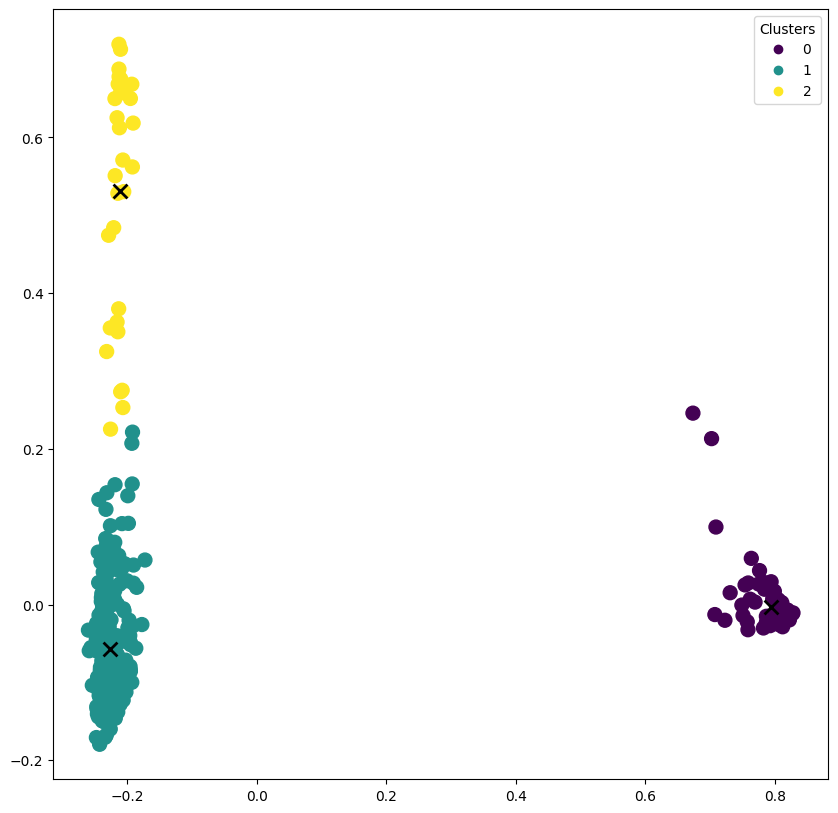

In [103]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")